In [125]:
# !pip install gensim
# !pip install scipy==1.12
# !pip install stop-words
# !pip install torch
# !pip install transformers
# !pip install scikit-learn
# !pip install nltk
# !pip install protobuf
# !pip install pyLDAvis

In [3]:
import pandas as pd
# from tqdm.notebook import tqdm as tqdm_notebook
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import seaborn as sns
import gensim
import copy
import time
import numpy as np
import torch
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import nltk
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk.tokenize import RegexpTokenizer


# nltk.download('stopwords')
# nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = stopwords.words('russian')
stop_words.extend(['доброго', 'времени', 'суток'])

%matplotlib inline

In [4]:
df = pd.read_csv('tickets_processed_llm.csv', index_col=False)

In [131]:
df.theme.unique()[30:100]

array(['Жалоба абонента  TT20612336', 'Жалоба абонента  TT20612764',
       'Отключить сим ремайндер', 'IM00053113', 'test',
       'Жалоба абонента  TT20609043', 'Жалоба абонента  TT20609074',
       'Жалоба абонента  TT20609627', 'Жалоба абонента  TT20608963',
       'Жалоба абонента  TT20611963', 'Жалоба абонента  TT20612248',
       'Жалоба абонента  TT20612476', 'Жалоба абонента  TT20613581',
       'Жалоба абонента  TT20613647', 'Жалоба абонента  TT20613233',
       'Жалоба абонента  TT20613463', 'Жалоба абонента  TT20614032',
       'ЧС по 99993 от 04.01.2023',
       'Представление кода активации esim в формате, поддерживаемом часами',
       'Жалоба абонента  TT20614762', 'Жалоба абонента  TT20614604',
       'Отключение', 'Жалоба абонента  TT20615351',
       'Жалоба абонента  TT20615524', 'Жалоба абонента  TT20615500',
       'Жалоба абонента  TT20615785', 'Жалоба абонента  TT20618628',
       'Жалоба абонента  TT20619200', 'Siemens',
       'Отказ от push-уведомлений', 'Жал

# Clustering analysis

Для векторизации текста использовалась модель LaBSE от @cointegrated, BERT и Word2Vec.
Подберем количество кластеров

In [35]:
# tokenizer = RegexpTokenizer(r'\w+')

# def preprocess(text):
#     tokens = ' '.join(tokenizer.tokenize(text))

#     return ' '.join([word for word in tokens.lower().split() if word not in stop_words])
#df['sentences'] = df['descr'].astype(str) + df['theme'].astype(str)

In [14]:
df.texts_cmb = df.texts_cmb.astype(str)

### W2Vec Vectorization

In [84]:
df = pd.read_csv('tickets_processed.csv', index_col=False)
w2v_model = gensim.models.Word2Vec.load("word2vec.model")
# Получение среднего вектора для каждого текста
df.texts_cmb = df.texts_cmb.astype(str)
texts_tokenized = [text.split() for text in df['texts_cmb']]

In [85]:
df.texts_cmb = df.texts_cmb.astype(str)
df['mean_vector'] = df['texts_cmb'].apply(lambda x: get_mean_vector(x.split()))
print(df[['mean_vector']].head())

                                         mean_vector
0  [-0.013772563, 0.24305843, 0.33216837, 0.24765...
1  [0.014109146, 0.28484482, 0.5198607, 0.3259961...
2  [0.015412339, 0.30873173, 0.5468674, 0.2782279...
3  [0.021456981, 0.32073426, 0.5626702, 0.2749143...
4  [0.026764978, 0.3145665, 0.49364448, 0.2986737...


In [86]:
embeddings = df.mean_vector.apply(pd.Series)

### LABSE Vectorization

In [27]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
model = AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")
embeddings_list = []

for s in df.texts_cmb:
    encoded_input = tokenizer(s, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    embedding = model_output.pooler_output
    embeddings_list.append((embedding)[0].numpy())


df['embeddings'] = embeddings_list
# df.to_csv('out.csv', index=False)

### RUBERT Vectorization

In [61]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum lengt

In [79]:
embeddings_list = []
for s in df.texts_cmb:
    input = tokenizer(s, padding=True, truncation=True, return_tensors='pt')
    # Get the BERT embeddings
    with torch.no_grad():
        output = model(**input)
    # output['last_hidden_state'] contains the token-level embeddings for each word
    token_embedding = output.last_hidden_state  # (batch_size, sequence_length, hidden_size)
    embedding = token_embedding[:, 0, :]  # (batch_size, hidden_size)
    embedding = torch.nn.functional.normalize(embedding, p=2, dim=1)

    embeddings_list.append((embedding)[0].numpy())

In [81]:
embeddings = np.asarray(embeddings_list)
# df['embeddings'] = embeddings_list

## KMeans

#### Word2Vec

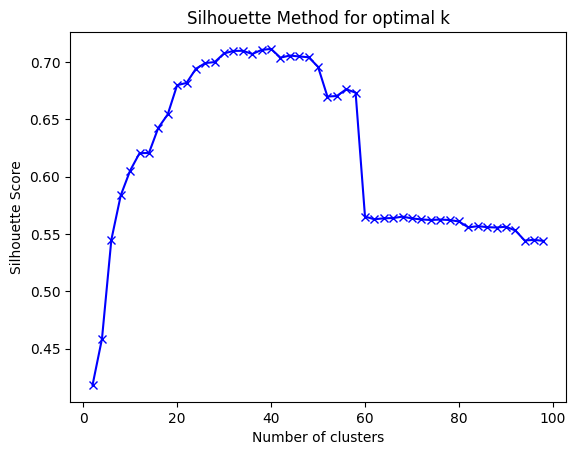

In [87]:
# Подберем количество кластеров для Word2Vec

k_values = [x for x in range(2, 100, 2)]

silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=100).fit(embeddings)
    score = silhouette_score(embeddings, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for optimal k')
plt.show()

#### LABSE

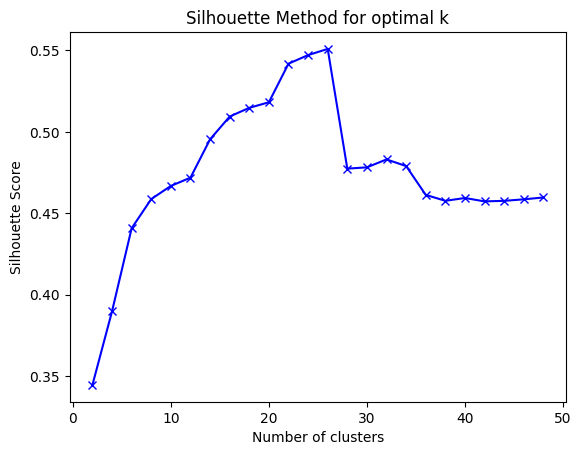

In [29]:
# Подберем количество кластеров для LABSE

k_values = [x for x in range(2, 50, 2)]

silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=100).fit(embeddings)
    score = silhouette_score(embeddings, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for optimal k')
plt.show()

Коэффициенты изменяются от -1 до 1. Значения, близкие к 1, указывают на то, что объект является похожим на другие объекты в кластере и не похожим на объекты из других кластеров. Если большинство объектов имеют значения коэффициентов близкими к 1, можно утверждать, что кластерная структура хорошо выражена, и количество кластеров соответствует естественной группировке данных.

Заметим, что наилучший результат достигается на 25 кластерах

In [33]:
kmeans = KMeans(n_clusters = 25, random_state = 100500).fit(embeddings)
kmeans_labels = kmeans.labels_

kmeans.cluster_centers_ = kmeans.cluster_centers_.astype(np.float32)

In [34]:
data = pd.DataFrame()
data['text'] = df.texts_cmb
data['label'] = kmeans_labels
data['embedding'] = list(embeddings)

In [35]:
ypred = kmeans.predict(embeddings)

In [36]:
kmeans_centers = kmeans.cluster_centers_
top_texts_list = []
for i in range (0, 25):
    cluster = data[data['label'] == i]
    embeddings = list(cluster['embedding'])
    texts = list(cluster['text'])
    distances = [euclidean_distances(kmeans_centers[0].reshape(1, -1), e.reshape(1, -1))[0][0] for e in embeddings]
    scores = list(zip(texts, distances))
    top_3 = sorted(scores, key=lambda x: x[1])[:3]
    top_texts = list(zip(*top_3))[0]
    top_texts_list.append(top_texts)

In [37]:
data.groupby('label')['label'].sum()

label
0         0
1       546
2      1054
3       705
4      1380
5      3225
6      1548
7      2205
8       480
9     30618
10     3420
11     1430
12     2112
13     2184
14     2408
15     1695
16     7296
17     2380
18     3960
19     2090
20     5420
21    12222
22     2244
23     5750
24     3240
Name: label, dtype: int32

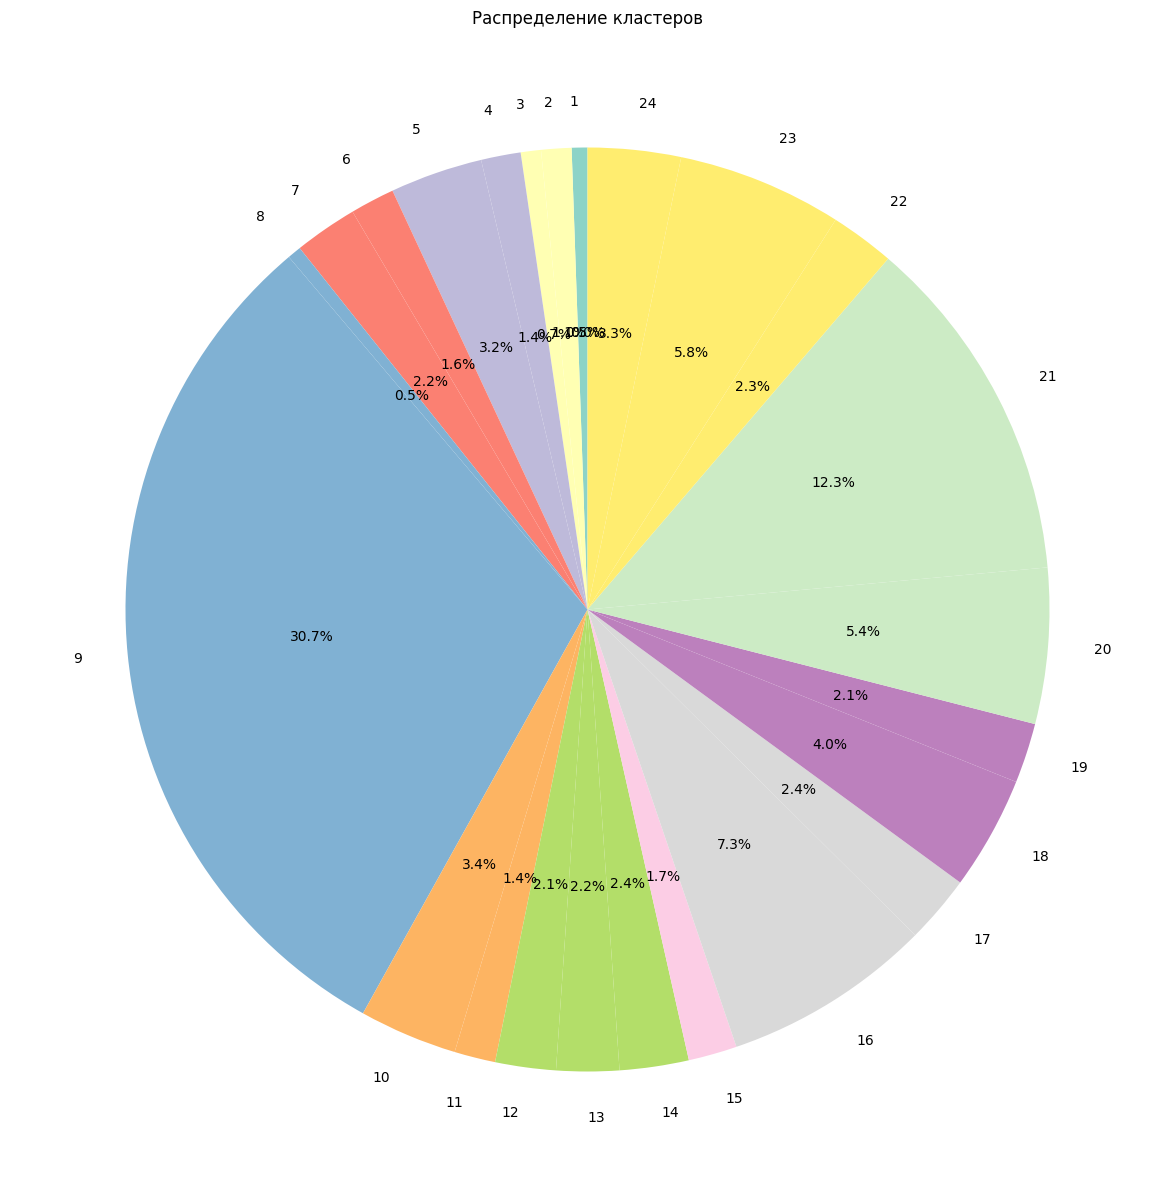

In [38]:
label_counts = data.groupby('label')['label'].sum()

# Plot a pie chart
plt.figure(figsize=(15, 15)) 
label_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='Set3')
plt.ylabel('')
plt.title('Распределение кластеров')
plt.show()

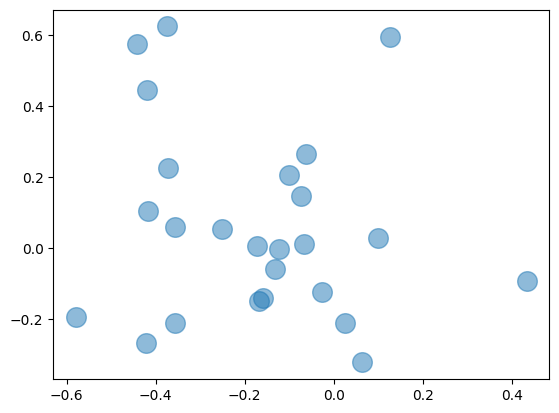

In [39]:
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=200, alpha=0.5);

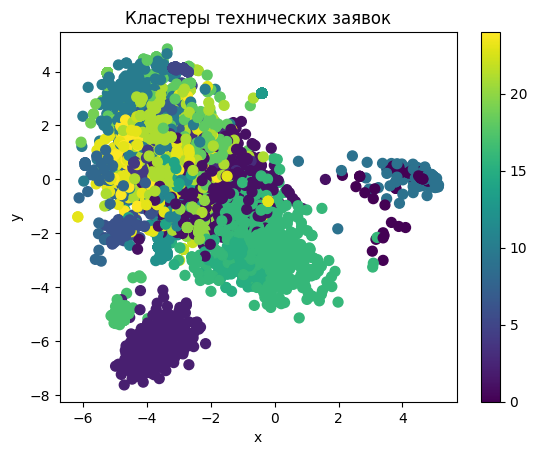

In [42]:
# Reduce dimensionality to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plotting
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=ypred, s=50)
plt.colorbar()  # Optional: Add color bar to see the mapping of colors to classes
plt.xlabel('x')
plt.ylabel('y')
plt.title('Кластеры технических заявок')
plt.show()

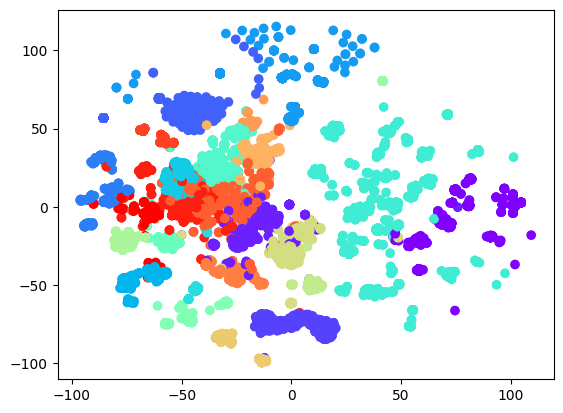

In [43]:
# t-SNE для визуализации
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(embeddings)

# Визуализация кластеров
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=ypred, cmap='rainbow')
plt.show()

Посмотрим примеры кластеров

In [44]:
with pd.option_context('display.max_colwidth', None):
    display(data[data['label'] == 10][['text']])

,text
63,. вечер . мочь установить esimич вручную qr-код делать найти инструкция установка . инструкция мегафон работать . заранее спасибо .
123,. хотеть худеть отправить
134,1-система ру . supporta1-systems . ру . a1-systems .
186,. система система . система есим .
214,семинар командировочный и представительский расход новый требование к документирование . -gt -gt -gt смотреть письмо веб-браузерекомандировочный представительский расход . новый требование документирование соответствие фсб документ документооборот бухгалтерский учёт . пользоваться корпоративный карта . принимать бухгалтерский налоговый учёт . январь 2023г . г . москваозерковский наб . стр . 1предусмотреть вариант участие очно онлайн . спикер попов елена павлович налоговый консультант профессиональный бухгалтер пр .
...,...
10167,сие . есим .
10184,бюджетный регистрация на всероссийский конференция инжиниринг как средство повышение конкурентоспособность страна .
10201,менее два неделя до форум о ит в лесопромышленный комплекс россия .
10216,. mobisad-imex .


In [45]:
with pd.option_context('display.max_colwidth', None):
    display(data[data['label'] == 9][['text']])

,text
1,жалоба абонент . абонент утверждать заказывать . просить проверить корректность списание рассмотреть вопрос компенсация . просьба отключить абонент подписка . номер подключить подписка номер телефон . б2с дата подключение подписка б2б дата необходимо скорректировать денежный средство .
8,жалоба абонент . абонент утверждать заказывать . просить проверить корректность списание рассмотреть вопрос компенсация . просьба отключить абонент подписка . номер подключить подписка номер телефон . б2с дата подключение подписка б2б дата необходимо скорректировать денежный средство . номер провайдер дс инвойс .
9,жалоба абонент . абонент утверждать заказывать . просить проверить корректность списание рассмотреть вопрос компенсация . просьба отключить абонент подписка . номер подключить подписка номер телефон . б2с дата подключение подписка б2б дата необходимо скорректировать денежный средство .
14,жалоба абонент . абонент утверждать заказывать . просить проверить корректность списание рассмотреть вопрос компенсация . просьба отключить абонент подписка . номер подключить подписка номер телефон . б2с дата подключение подписка б2б дата необходимо скорректировать денежный средство . номер провайдер дс инвойс розница номер подписка вд .
17,жалоба абонент . абонент утверждать заказывать . просить проверить корректность списание рассмотреть вопрос компенсация . просьба отключить абонент подписка . номер подключить подписка номер телефон . б2с дата подключение подписка б2б дата необходимо скорректировать денежный средство . номер провайдер дс инвойс розница номер подписка .
...,...
10262,жалоба абонент . абонент утверждать заказывать . просить проверить корректность списание рассмотреть вопрос компенсация . просьба отключить абонент подписка . номер подключить подписка номер телефон . б2с дата подключение подписка б2б дата необходимо скорректировать денежный средство . номер провайдер дс инвойс розница номер подписка вд номер телефон . сумма п .
10264,жалоба абонент . абонент утверждать заказывать . просить проверить корректность списание рассмотреть вопрос компенсация . просьба отключить абонент подписка . номер подключить подписка номер телефон . б2с дата подключение подписка б2б дата необходимо скорректировать денежный средство . номер провайдер дс инвойс розница номер подписка .
10266,жалоба абонент . абонент утверждать заказывать . просить проверить корректность списание рассмотреть вопрос компенсация . просьба отключить абонент подписка . номер подключить подписка номер телефон . б2с дата подключение подписка б2б дата необходимо скорректировать денежный средство . номер провайдер дс инвойс розница ном .
10267,жалоба абонент . абонент утверждать заказывать . просить проверить корректность списание рассмотреть вопрос компенсация . просьба отключить абонент подписка . номер подключить подписка номер телефон . б2с дата подключение подписка б2б дата необходимо скорректировать денежный средство . номер провайдер дс инвойс розница ном .


In [46]:
num_clusters = 25
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df.texts_cmb)

# Get the feature names (words)
terms = tfidf_vectorizer.get_feature_names_out()

# Assign sentences to clusters
clusters = {i: [] for i in range(num_clusters)}

for i, label in enumerate(data.label):
    clusters[label].append(i)

In [47]:
def get_top_keywords(cluster_sentences, top_n=5):
    cluster_tfidf = tfidf_matrix[cluster_sentences].mean(axis=0).flatten()
    sorted_indices = cluster_tfidf.argsort()[::-1]  # Sort in descending order
    top_terms = [terms[idx] for idx in sorted_indices[:top_n]]
    return top_terms

# Print top words for each cluster
for cluster, sentences_in_cluster in clusters.items():
    print(f"Cluster {cluster} Top Keywords: {get_top_keywords(sentences_in_cluster)}\n")

Cluster 0 Top Keywords: [array([['042022дат', 'потр', 'поток', ..., 'лишний', 'абонент',
        'подписка']], dtype=object)]

Cluster 1 Top Keywords: [array([['настаивать', 'планшет', 'плановый', ..., 'живой', 'проблема',
        'баланс']], dtype=object)]

Cluster 2 Top Keywords: [array([['042022дат', 'поп', 'понятный', ..., 'письмо', 'канал', 'это']],
      dtype=object)]

Cluster 3 Top Keywords: [array([['042022дат', 'почитать', 'почистить', ..., 'главный',
        'уведомление', 'клиент']], dtype=object)]

Cluster 4 Top Keywords: [array([['042022дат', 'почему', 'почасовой', ..., 'плановый', 'работа',
        'оператор']], dtype=object)]

Cluster 5 Top Keywords: [array([['042022дат', 'появляться', 'появляетсяописание', ..., 'список',
        'номер', 'телефон']], dtype=object)]

Cluster 6 Top Keywords: [array([['042022дат', 'потребительский', 'потребитель', ...,
        'технический', 'платформа', 'работа']], dtype=object)]

Cluster 7 Top Keywords: [array([['042022дат', 'понятно', 

#### BERT

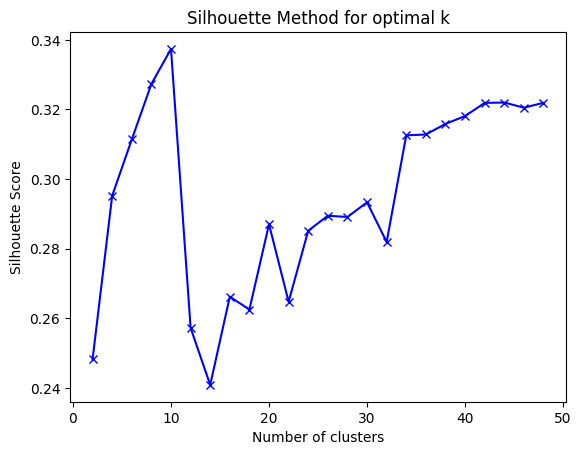

In [83]:
# Подберем количество кластеров
k_values = [x for x in range(2, 50, 2)]

silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=100).fit(embeddings)
    score = silhouette_score(embeddings, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for optimal k')
plt.show()

Данная оценка уже ближе к тому, что было просмотрено вручную

In [96]:
kmeans = KMeans(n_clusters = 10, random_state = 100500).fit(embeddings)
kmeans_labels = kmeans.labels_

kmeans.cluster_centers_ = kmeans.cluster_centers_.astype(np.float32)
ypred = kmeans.predict(embeddings)

In [99]:
data = pd.DataFrame()
data['text'] = df.texts_cmb
data['label'] = kmeans_labels

In [100]:
num_clusters = 10
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df.texts_cmb)

# Get the feature names (words)
terms = tfidf_vectorizer.get_feature_names_out()

# Assign sentences to clusters
clusters = {i: [] for i in range(num_clusters)}

for i, label in enumerate(data.label):
    clusters[label].append(i)

def get_top_keywords(cluster_sentences, top_n=5):
    cluster_tfidf = tfidf_matrix[cluster_sentences].mean(axis=0).flatten()
    sorted_indices = cluster_tfidf.argsort()[::-1]  # Sort in descending order
    top_terms = [terms[idx] for idx in sorted_indices[:top_n]]
    return top_terms

# Print top words for each cluster
for cluster, sentences_in_cluster in clusters.items():
    print(f"Cluster {cluster} Top Keywords: {get_top_keywords(sentences_in_cluster)}\n")

Cluster 0 Top Keywords: [array([['настаивать', 'отменять', 'отмена', ..., 'описание', 'номер',
        'проблема']], dtype=object)]

Cluster 1 Top Keywords: [array([['042022дат', 'диапазон', 'платф', ..., 'услуга', 'это', 'номер']],
      dtype=object)]

Cluster 2 Top Keywords: [array([['042022дат', 'потерить', 'потенциальный', ..., 'плановый',
        'работа', 'оператор']], dtype=object)]

Cluster 3 Top Keywords: [array([['042022дат', 'показывать', 'показаться', ..., 'берковен', 'ру',
        'доверительный']], dtype=object)]

Cluster 4 Top Keywords: [array([['042022дат', 'появиться', 'поэтому', ..., 'список', 'номер',
        'телефон']], dtype=object)]

Cluster 5 Top Keywords: [array([['042022дат', 'потерять', 'потеря', ..., 'абонент', 'номер',
        'подписка']], dtype=object)]

Cluster 6 Top Keywords: [array([['042022дат', 'почта', 'почка', ..., 'главный', 'уведомление',
        'клиент']], dtype=object)]

Cluster 7 Top Keywords: [array([['042022дат', 'пользование', 'пользов', 

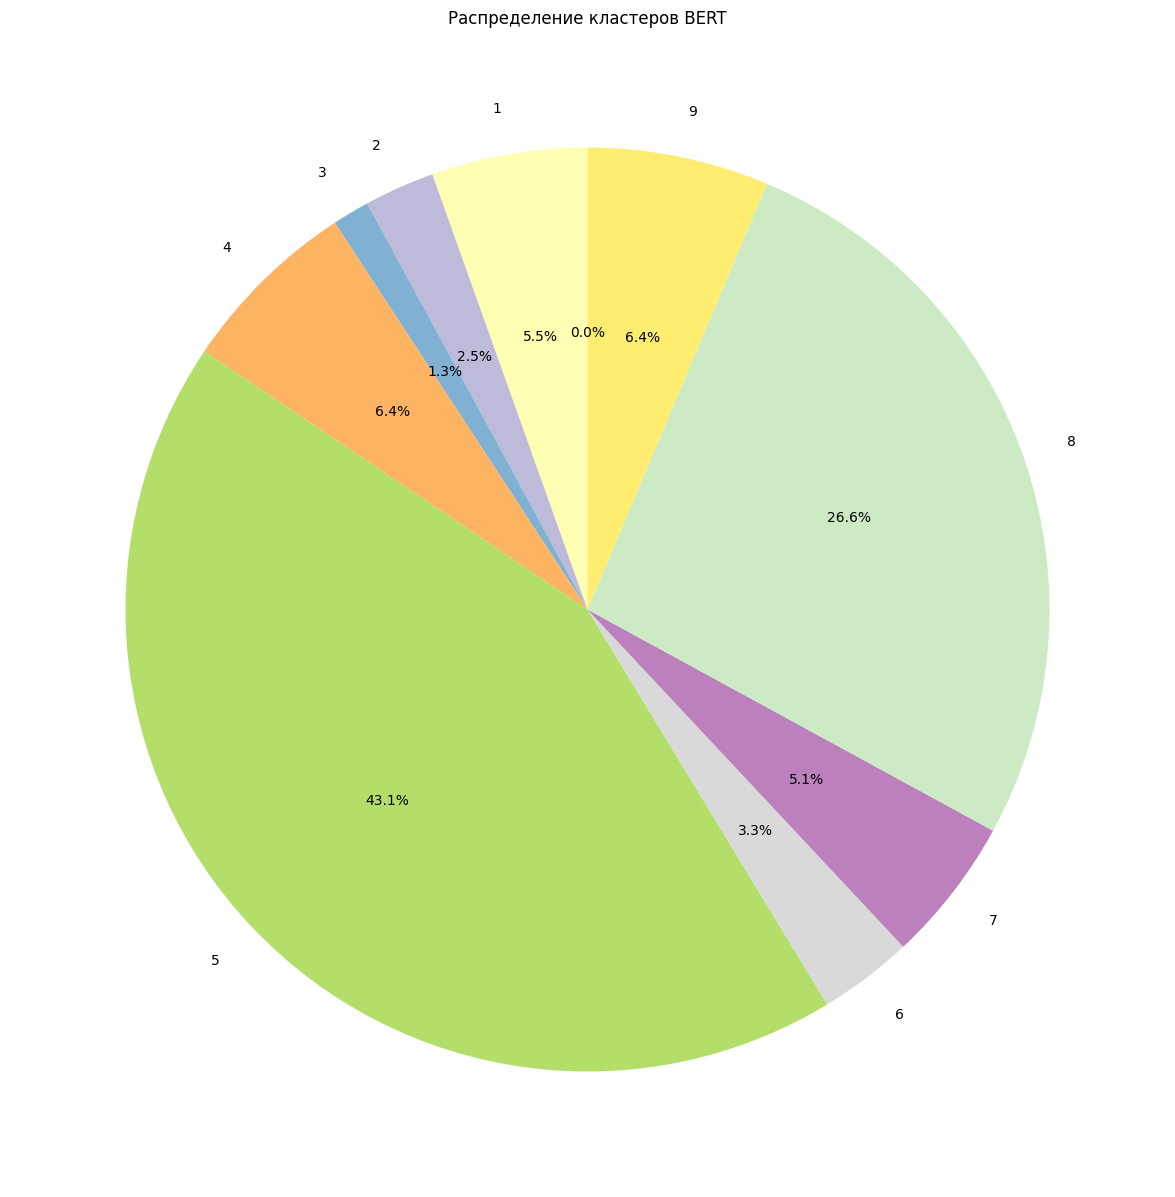

In [101]:
label_counts = data.groupby('label')['label'].sum()

# Plot a pie chart
plt.figure(figsize=(15, 15)) 
label_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='Set3')
plt.ylabel('')
plt.title('Распределение кластеров BERT')
plt.show()

In [102]:
with pd.option_context('display.max_colwidth', None):
    display(data[data['label'] == 9][['text']])

,text
5,уведомление сбой на сторона оператор теле2-казахстан . уважаемый партнёр . мск зафиксировать сбой сторона мобильный оператор теле2-казахстан . доставка сообщение абонент данный оператор затруднить мочь осуществляться задержка . данный момент доставка осуществляться штатный режим . информация оператор причина сбой данный момент поступать . отдел технический поддержка ао загрузка . номер телефон
52,отключение . дд просить отключить пуш ап уведомление номер номер телефон спс
122,жалоба абонент . абонент утверждать заказывать . просить проверить корректность списание рассмотреть вопрос компенсация . просьба отключить абонент подписка . номер подключить подписка номер телефон . б2с дата подключение подписка б2б дата необходимо скорректировать денежный средство . номер провайдер дс инвойс розница н .
126,черный список . день . просить отключить услуга добавить номер чс . также просить отписаться результат . заранее благодарить . уважение носир давлатбек муродбек уголь старший специалист группа анализ эффективность тело
251,уведомление о плановый работа у оператор тело . уважаемый партнёр . сотовый оператор теле2 сообщать необходимость проведение плановый технический работа . работа проводиться . период . мскgmt . указанный промежуток мочь наблюдаться затруднение доставка сообщение абонент данный оператор . отдел технический поддержка ао загрузка . номер телефон
...,...
9974,недоступность смс теле2 ру . коллега день фиксировать недоступность сервис . теле2 . rut2-black-list уточнить наблюдать проблема работа сервис свой сторона . уважение савилкина игорь ведущий инженер внедрение отдел эксплуатация внедрение центр компетенция дирекция ит
10039,оповещение о проведение работа . день номер телефон номер телефон производиться работа восстановление линк сервер t2ru-idgw-db-p07 t2ru-idgw-db-p04 случай возникновение аварийный ситуация работа возможно влияние указанный ке . уважение сергей мостуненко направление технологический развитие поддержка сервис платформа
10056,. день . просьба помочь решение проблема дата обнаружение проблема номер телефон наименование компания ооо сбербанк-телеком наименование услуга установка есим краткий описание заявкипроблема просьба предоставить информация обращение профиль полный описание заявка коллега просьба предоставить информация обращение профиль текущий статус значение счётчик установка . абонент номер телефон .
10081,уведомление о плановый на платформа ру . уважаемый партнёр . уведомлять плановый технический работа платформа . работа проводиться . мскgmt недоступность минута . работа затронуть сервис . благодарить понимание приносить извинение доставить неудобство . уважение команда номер телефон круглосуточно номер телефон звонок россия бесплатный


In [103]:
with pd.option_context('display.max_colwidth', None):
    display(data[data['label'] == 5][['text']])

,text
3,жалоба абонент . абонент утверждать заказывать . просить проверить корректность списание рассмотреть вопрос компенсация . просьба отключить абонент подписка . удалить лишний информация . номер подключить подписка номер телефон . б2с дата подключение подписка б2б дата необходимо скорректировать денежный средство . номер провайдер дс инвойс розница номер .
8,жалоба абонент . абонент утверждать заказывать . просить проверить корректность списание рассмотреть вопрос компенсация . просьба отключить абонент подписка . номер подключить подписка номер телефон . б2с дата подключение подписка б2б дата необходимо скорректировать денежный средство . номер провайдер дс инвойс .
14,жалоба абонент . абонент утверждать заказывать . просить проверить корректность списание рассмотреть вопрос компенсация . просьба отключить абонент подписка . номер подключить подписка номер телефон . б2с дата подключение подписка б2б дата необходимо скорректировать денежный средство . номер провайдер дс инвойс розница номер подписка вд .
17,жалоба абонент . абонент утверждать заказывать . просить проверить корректность списание рассмотреть вопрос компенсация . просьба отключить абонент подписка . номер подключить подписка номер телефон . б2с дата подключение подписка б2б дата необходимо скорректировать денежный средство . номер провайдер дс инвойс розница номер подписка .
19,жалоба абонент . абонент утверждать заказывать . просить проверить корректность списание рассмотреть вопрос компенсация . просьба отключить абонент подписка . номер подключить подписка номер телефон . б2с дата подключение подписка б2б дата необходимо скорректировать денежный средство . номер провайдер дс инвойс розница номер подписка вд .
...,...
10266,жалоба абонент . абонент утверждать заказывать . просить проверить корректность списание рассмотреть вопрос компенсация . просьба отключить абонент подписка . номер подключить подписка номер телефон . б2с дата подключение подписка б2б дата необходимо скорректировать денежный средство . номер провайдер дс инвойс розница ном .
10267,жалоба абонент . абонент утверждать заказывать . просить проверить корректность списание рассмотреть вопрос компенсация . просьба отключить абонент подписка . номер подключить подписка номер телефон . б2с дата подключение подписка б2б дата необходимо скорректировать денежный средство . номер провайдер дс инвойс розница ном .
10268,жалоба абонент . абонент утверждать заказывать . просить проверить корректность списание рассмотреть вопрос компенсация . просьба отключить абонент подписка . номер подключить подписка номер телефон . б2с дата подключение подписка б2б дата необходимо скорректировать денежный средство . номер провайдер дс инвойс розница номер подписка вд .
10270,жалоба абонент . абонент утверждать заказывать . просить проверить корректность списание рассмотреть вопрос компенсация . просьба отключить абонент подписка . удалить лишний информация . номер подключить подписка номер телефон . б2с дата подключение подписка б2б дата необходимо скорректировать денежный средство . номер провайдер дс инвойс дл .


## DBSCAN

In [48]:
# Нормализация данных перед кластеризацией
scaler = StandardScaler()
data_scaled = scaler.fit_transform(embeddings)

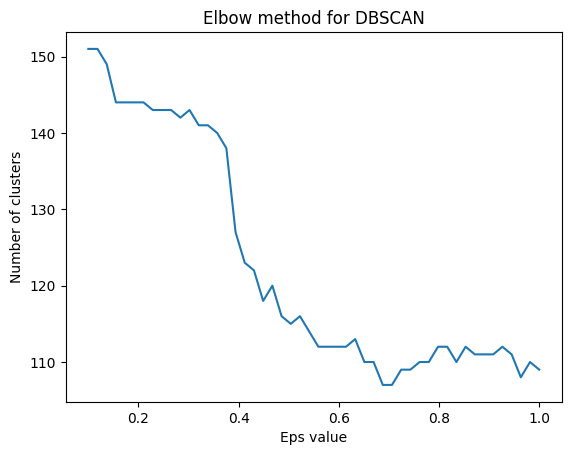

In [49]:
# Диапазон значений для eps
eps_values = np.linspace(0.1, 1.0, 50)
num_clusters = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(embeddings)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    num_clusters.append(n_clusters)

# Uрафик зависимости количества кластеров от значения eps
plt.plot(eps_values, num_clusters)
plt.xlabel("Eps value")
plt.ylabel("Number of clusters")
plt.title("Elbow method for DBSCAN")
plt.show()

In [50]:
dbscan = DBSCAN(eps=1, min_samples=51)
labels = dbscan.fit_predict(embeddings)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f'Найдено {n_clusters} кластеров (включая шум)')

Найдено 12 кластеров (включая шум)


C:\Users\Администратор\AppData\Local\Temp\ipykernel_28284\2177512060.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', len(unique_labels))


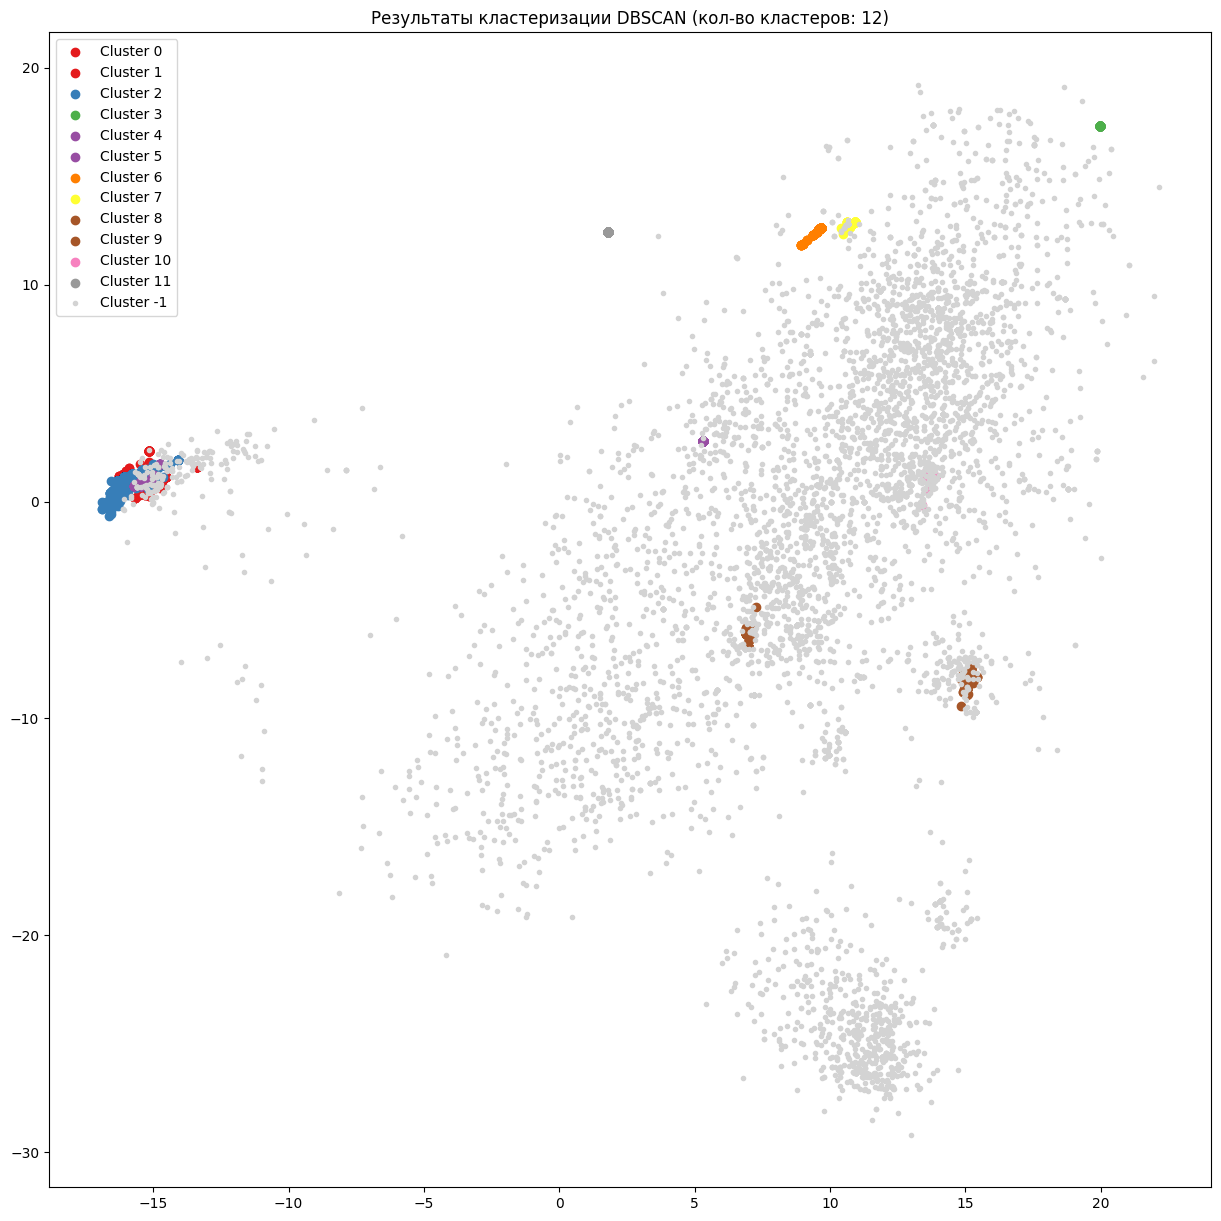

In [51]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Визуализация результатов
plt.figure(figsize=(15, 15))
unique_labels = set(labels)
colors = plt.cm.get_cmap('Set1', len(unique_labels))

for label in unique_labels:
    if label == -1:
        color = 'lightgrey'
        marker = '.'
        label_name = 'Noise'
    else:
        color = colors(label)
        marker = 'o'
    
    plt.scatter(data_pca[labels == label, 0], data_pca[labels == label, 1], 
                c=[color], label=f'Cluster {label}', marker=marker)

plt.title(f'Результаты кластеризации DBSCAN (кол-во кластеров: {n_clusters})')
plt.legend()
plt.show()

# Summarization

In [19]:
import torch
from transformers import AutoModelForTokenClassification, AutoTokenizer
model_name = 'cointegrated/rubert-tiny2-sentence-compression'
model = AutoModelForTokenClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [20]:
summary_list = []

def compress(text, threshold=0.8, keep_ratio=None):
    """ Compress a sentence by removing the least important words.
    Parameters:
        threshold: cutoff for predicted probabilities of word removal
        keep_ratio: proportion of words to preserve
    By default, threshold of 0.5 is used.
    """
    with torch.inference_mode():
        tok = tokenizer(text, return_tensors='pt').to(model.device)
        proba = torch.softmax(model(**tok).logits, -1).cpu().numpy()[0, :, 1]
    if keep_ratio is not None:
        threshold = sorted(proba)[int(len(proba) * keep_ratio)]
    kept_toks = []
    keep = False
    prev_word_id = None
    for word_id, score, token in zip(tok.word_ids(), proba, tok.input_ids[0]):
        if word_id is None:
            keep = True
        elif word_id != prev_word_id:
            keep = score < threshold
        if keep:
            kept_toks.append(token)
        prev_word_id = word_id
    return tokenizer.decode(kept_toks, skip_special_tokens=True)

for s in df.texts_cmb:
    summary_list.append(compress(s))

Саммаризация для тикетов не требуется, т.к. удяются важные слова для кластеризации. Она будет использоваться для статей на вики для технической поддержки

# LDA Model

In [5]:
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamodel import LdaModel
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.topic_coherence import direct_confirmation_measure
from nltk.tokenize import word_tokenize

In [17]:
with pd.option_context('display.max_colwidth', None):
    display(df['texts_cmb'])

0                                                                                                   [жалоба, абонент, просьба, ответ, запрос, использовать, функция, ответить, весь, абонент, всплывать, блокировать, работа, просьба, отключить, функционал, апплет, абонент, дата, заказ, провайдер, кц, инвойс, розница, подписка, вд, описание, проблема, отключаться, меню, текст, сообщение, эк]
1                                                                                                                    [жалоба, абонент, абонент, утверждать, заказывать, просить, проверить, корректность, списание, рассмотреть, вопрос, компенсация, просьба, отключить, абонент, подписка, подключить, подписка, дата, подключение, подписка, дата, необходимо, скорректировать, денежный, средство]
2                                                                [жалоба, абонент, абонент, утверждать, заказывать, просить, проверить, корректность, списание, рассмотреть, вопрос, компенсация, просьба, отключить, абон

In [8]:
def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# Применяем предобработку к колонке
df['texts_cmb'] = df['texts_cmb'].apply(preprocess)

In [10]:
# Создание словаря и корпуса
dictionary = corpora.Dictionary(df.texts_cmb)

# Преобразуем документы в bag-of-words (мешок слов)
corpus = [dictionary.doc2bow(text) for text in df['texts_cmb']]

In [19]:
params = {'alpha': 'symmetric', 'eta': 'symmetric', 'iterations': 50, 'num_topics': 10, 'passes': 10}

lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=params['num_topics'],
                         alpha=params['alpha'],
                         eta=params['eta'],
                         iterations=params['iterations'],
                         passes=params['passes'],
                         random_state=42)


In [20]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['texts_cmb'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print(f'Когерентность модели: {coherence_lda}')

Когерентность модели: 0.7167755327220832


In [21]:
topics = lda_model.print_topics(num_words=5)
for topic_num, topic in topics:
    print(f"Тема {topic_num}: {topic}")

Тема 0: 0.077*"работа" + 0.048*"интерфейс" + 0.041*"платформа" + 0.035*"технический" + 0.029*"услуга"
Тема 1: 0.074*"оператор" + 0.048*"работа" + 0.032*"сообщение" + 0.030*"плановый" + 0.028*"данный"
Тема 2: 0.064*"услуга" + 0.059*"письмо" + 0.039*"абонент" + 0.033*"описание" + 0.033*"название"
Тема 3: 0.060*"канал" + 0.033*"учётный" + 0.033*"запись" + 0.030*"просить" + 0.029*"ватсапп"
Тема 4: 0.028*"услуга" + 0.025*"случай" + 0.024*"любой" + 0.024*"наличие" + 0.023*"номер"
Тема 5: 0.117*"подписка" + 0.090*"абонент" + 0.056*"дата" + 0.043*"отключить" + 0.037*"просьба"
Тема 6: 0.054*"просить" + 0.044*"клиент" + 0.038*"список" + 0.035*"специалист" + 0.033*"добавить"
Тема 7: 0.049*"просьба" + 0.041*"есим" + 0.041*"проблема" + 0.041*"решение" + 0.038*"обнаружение"
Тема 8: 0.120*"рассылка" + 0.106*"сообщение" + 0.055*"предназначить" + 0.050*"данный" + 0.040*"информация"
Тема 9: 0.074*"абонент" + 0.060*"вызов" + 0.028*"ответить" + 0.026*"запрос" + 0.024*"жалоба"


In [28]:
# Получение темы для каждого документа
def get_topic_for_document(lda_model, bow):
    topics = lda_model.get_document_topics(bow)
    # Возьмем тему с самой высокой вероятностью
    topic = max(topics, key=lambda x: x[1])[0]
    return topic

df["topic"] = [get_topic_for_document(lda_model, bow) for bow in corpus]

df.head()

,Unnamed: 0,start_dt,end_dt,sender_name,sender_email,theme,descr,sender_name_cut,texts_cmb,topic
0,0,2023-01-01 08:22:15+00,2023-01-01 19:14:50+00,content_problem,content_problem@tele2.ru,Жалоба абонента TT20595877,. Доброго времени суток! ПРОСЬБА ПРИ ОТВЕТЕ НА...,content_problem,"[жалоба, абонент, просьба, ответ, запрос, испо...",9
1,1,2023-01-01 11:18:47+00,2023-01-01 19:18:36+00,content_problem,content_problem@tele2.ru,Жалоба абонента TT20592639,"Доброго времени суток! Абонент утверждает, что...",content_problem,"[жалоба, абонент, абонент, утверждать, заказыв...",5
2,2,2023-01-01 12:31:00+00,2023-01-01 18:52:48+00,content_problem,content_problem@tele2.ru,Жалоба абонента TT20594559,"Доброго времени суток! Абонент утверждает, что...",content_problem,"[жалоба, абонент, абонент, утверждать, заказыв...",5
3,3,2023-01-01 13:15:12+00,2023-01-01 18:51:01+00,content_problem,content_problem@tele2.ru,Жалоба абонента TT20593507,"Доброго времени суток! Абонент утверждает, что...",content_problem,"[жалоба, абонент, абонент, утверждать, заказыв...",5
4,4,2023-01-01 13:15:12+00,2023-01-01 18:52:00+00,content_problem,content_problem@tele2.ru,Жалоба абонента TT20593899,"Доброго времени суток! Абонент утверждает, что...",content_problem,"[жалоба, абонент, абонент, утверждать, заказыв...",5


In [34]:
with pd.option_context('display.max_colwidth', None):
    display(df[df['topic'] == 1][['texts_cmb']])

,texts_cmb
5,"[уведомление, сбой, сторона, оператор, уважаемый, партнёр, мск, зафиксировать, сбой, сторона, мобильный, оператор, доставка, сообщение, абонент, данный, оператор, затруднить, мочь, осуществляться, задержка, данный, момент, доставка, осуществляться, штатный, режим, информация, оператор, причина, сбой, данный, момент, поступать, отдел, технический, поддержка, ао, загрузка]"
13,"[политика, обновление, ваш, пароль, доставка, сообщение, доставка, сообщение, диагностика, информация, сервер]"
197,"[удаваться, доставить, политика, обновление, ваш, пароль, удаться, выполнить, доставка, следующий, получатель, группа, почтовый, ящик, получатель, заполнить, данный, момент, мочь, принимать, сообщение, попробовать, снова, отправить, письмо, поздний, обратиться, получатель, напрямую, организация, отклонить, сообщение, диагностический, сведение, администратор, формировать, сервер, сервер]"
251,"[уведомление, плановый, работа, оператор, тело, уважаемый, партнёр, сотовый, оператор, сообщать, необходимость, проведение, плановый, технический, работа, работа, проводиться, период, мскgmt, указанный, промежуток, мочь, наблюдаться, затруднение, доставка, сообщение, абонент, данный, оператор, отдел, технический, поддержка, ао, загрузка]"
277,"[политика, обновление, ваш, пароль, доставка, мэилбокс, сообщение, сообщение, диагностика, информация, сервер, сервер, мэилбокс]"
...,...
10129,"[уведомление, плановый, работа, оператор, мегафон, уважаемый, партнёр, сотовый, оператор, мегафон, сообщать, необходимость, проведение, плановый, технический, работа, работа, проводиться, период, мскgmt, указанный, промежуток, мочь, наблюдаться, затруднение, доставка, сообщение, абонент, данный, оператор, уважение, команда, круглосуточно, звонок, россия, бесплатный]"
10131,"[уведомление, плановый, работа, оператор, мтс, уважаемый, партнёр, сотовый, оператор, мтс, сообщать, необходимость, проведение, плановый, технический, работа, работа, проводиться, период, мскgmt, указанный, промежуток, мочь, наблюдаться, затруднение, доставка, сообщение, абонент, данный, оператор, уважение, команда, круглосуточно, звонок, россия, бесплатный]"
10135,"[уведомление, восстановление, сервис, отправка, сообщение, абонент, оператор, спринт, уважаемый, партнёр, фиксировать, восстановление, сервис, доставка, сообщение, абонент, сотовый, оператор, спринт, проблема, наблюдаться, информация, устранение, сбой, оператор, данный, момент, поступать, уважение, команда, круглосуточно, звонок, россия, бесплатный]"
10170,"[уведомление, плановый, работа, оператор, мегафон, уважаемый, партнёр, сотовый, оператор, мегафон, сообщать, необходимость, проведение, плановый, технический, работа, работа, проводиться, мскgmt, указанный, промежуток, мочь, наблюдаться, затруднение, доставка, сообщение, абонент, данный, оператор, уважение, команда, круглосуточно, звонок, россия, бесплатный]"


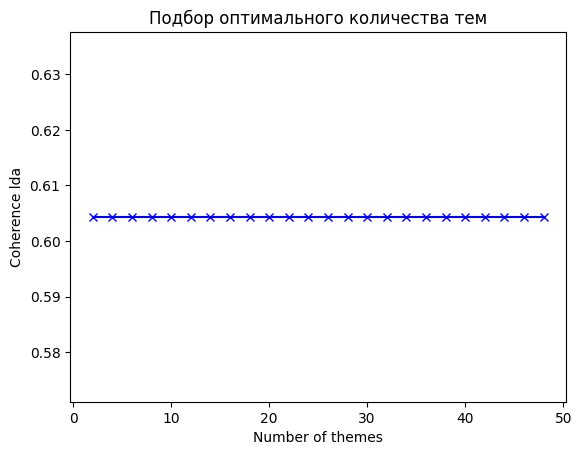

In [126]:
# Подберем количество тем
k_values = [x for x in range(2, 50, 2)]

coherence_lda_scores = []

for k in k_values:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df['texts_cmb'], dictionary=dictionary, coherence='c_v')
    score = coherence_model_lda.get_coherence()
    coherence_lda_scores.append(score)

plt.plot(k_values, coherence_lda_scores, 'bx-')
plt.xlabel('Number of themes')
plt.ylabel('Coherence lda')
plt.title('Подбор оптимального количества тем')
plt.show()

In [22]:
import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()  # Для Jupyter Notebook
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

Выводы:
1. Дополнить предобработку данных
2. Настроить гиперпараметры

In [12]:
from sklearn.model_selection import ParameterGrid

# Функция для вычисления когерентности модели LDA
def compute_coherence(lda_model, texts, dictionary):
    coherence_model = CoherenceModel(model=lda_model, texts=df['texts_cmb'], dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

param_grid = {
    'num_topics': [2, 10, 25,  50],           # количество тем
    'alpha': ['symmetric', 'asymmetric', 0.01, 0.1],  # параметры альфа
    'eta': ['symmetric', 0.01, 0.1],   # параметры эта
    'iterations': [50, 100],           # количество итераций
    'passes': [5, 10]                  # количество проходов
}

# Используем ParameterGrid для генерации всех комбинаций
grid = list(ParameterGrid(param_grid))

# Перебираем все комбинации параметров
best_coherence = -np.inf  # Инициализируем для хранения лучшей когерентности
best_params = None        # Сохраним лучшие параметры
best_model = None         # Сохраним лучшую модель

for params in grid:
    print(f"Тестирование параметров: {params}")

    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=params['num_topics'],
                         alpha=params['alpha'],
                         eta=params['eta'],
                         iterations=params['iterations'],
                         passes=params['passes'],
                         random_state=42)

    coherence = compute_coherence(lda_model, df['texts_cmb'], dictionary)
    
    print(f"Когерентность: {coherence}")

    if coherence > best_coherence:
        best_coherence = coherence
        best_params = params
        best_model = lda_model

print(f"\nЛучшая когерентность: {best_coherence}")
print(f"Лучшие параметры: {best_params}")

Тестирование параметров: {'alpha': 'symmetric', 'eta': 'symmetric', 'iterations': 50, 'num_topics': 2, 'passes': 5}
Когерентность: 0.6261064906065105
Тестирование параметров: {'alpha': 'symmetric', 'eta': 'symmetric', 'iterations': 50, 'num_topics': 2, 'passes': 10}
Когерентность: 0.6261064906065105
Тестирование параметров: {'alpha': 'symmetric', 'eta': 'symmetric', 'iterations': 50, 'num_topics': 10, 'passes': 5}
Когерентность: 0.6573680393660395
Тестирование параметров: {'alpha': 'symmetric', 'eta': 'symmetric', 'iterations': 50, 'num_topics': 10, 'passes': 10}
Когерентность: 0.6693743484963228
Тестирование параметров: {'alpha': 'symmetric', 'eta': 'symmetric', 'iterations': 50, 'num_topics': 25, 'passes': 5}
Когерентность: 0.6361754270058344
Тестирование параметров: {'alpha': 'symmetric', 'eta': 'symmetric', 'iterations': 50, 'num_topics': 25, 'passes': 10}
Когерентность: 0.6288981236538759
Тестирование параметров: {'alpha': 'symmetric', 'eta': 'symmetric', 'iterations': 50, 'num_to

# Предварительные темы

```
1. Обращения
   1 Списания/денежные средства
   2 Проблемы с сим-меню
   3 Esim (код активации, qr-код)
   4 Отключение услуги
   5 Учетные записи
2. Информация
   6 Уведомления о плановых работах
   6 Сбой работы (в работе оператора)
3. Черный список
4. Спам
```

In [35]:
# Сохраним модель, корпус слов и словарь

lda_model.save('lda_model.model')
dictionary.save('dictionary.dict')
gensim.corpora.MmCorpus.serialize('corpus.mm', corpus)
df.to_csv('labelled_tickets.csv',index=False)

In [ ]:
# Загрузим модель, корпус слов и словарь

# lda_model = gensim.models.LdaModel.load('lda_model.model')
# dictionary = corpora.Dictionary.load('dictionary.dict')
# corpus = gensim.corpora.MmCorpus('corpus.mm')